## The code contains LDOS spectrum, Mode acquiring, flux spectrum. 

In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
import math as math
from meep.materials import Au,SiO2

In [2]:
GaAs=mp.Medium(index=3.885)
#SiO2=mp.Medium(index=1.4500)
#Au=mp.Medium(index=0.3970)
w=0.16
d=0.34
cr=0.55
num=11
pad=2
dpml=2
tGaAs=0.24
tSiO2=0.3
tAu=0.1
sxy =2*(num*(d+w)+cr+pad+dpml)
sz=2*dpml+tGaAs+tSiO2+tAu+2*pad
cellsize=mp.Vector3(sxy,sxy,sz)

In [3]:
geometry=[]
basis=mp.Cylinder(center=mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs-tSiO2/2),
                         radius=num*(w+d)+cr,
                         height=tSiO2,
                         material=SiO2)
Aufilm=mp.Cylinder(center=mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs-tSiO2-tAu/2),
                         radius=num*(w+d)+cr,
                         height=tAu,
                         material=Au)

for i in range(1,num*2+1):
    if i & 1 != 0: #if odd
        geometry=geometry+[mp.Cylinder(center=mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs/2),
                         radius=(num*2+1-i)/2*d+(num*2+1-i)/2*w+cr,
                         height=tGaAs,
                         material=GaAs)]
    else:
        geometry=geometry+[mp.Cylinder(center=mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs/2),
                         radius=(num*2-i+2)/2*w+((num*2+2-i)/2-1)*d+cr,
                         height=tGaAs)]
        
indisk=mp.Cylinder(center=mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs/2),
                         radius=cr,
                         height=tGaAs,
                         material=GaAs)

geometry.append(indisk)
geometry.append(basis)
geometry.append(Aufilm)


In [4]:
wvlmax=1.6
wvlmin=1.3
fmax=1/wvlmin
fmin=1/wvlmax

fcen =0.5*(1/wvlmin+1/wvlmax)            # pulse center frequency
df = 1/wvlmax- 1/wvlmin            # pulse frequency width
src = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                mp.Ey,
                mp.Vector3(0,0,0.5*sz-dpml-pad-tGaAs/2))]
symmetries=[mp.Mirror(mp.X,-1), mp.Mirror(mp.Y,+1)]

In [5]:
sim = mp.Simulation(cell_size=cellsize,
                    geometry=geometry,
                    resolution=60, 
                    sources=src,
                    boundary_layers=[mp.PML(dpml)],
                    dimensions=3,
                    symmetries=symmetries,
                    Courant=0.5)

-----------
Initializing structure...
Padding x to even number of grid points.
Padding y to even number of grid points.
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00434709 s
Working in 3D dimensions.
Computational cell is 20.1 x 20.1 x 8.64 with resolution 50
     cylinder, center = (0,0,0.2)
          radius 6.05, height 0.24, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15.0932,15.0932,15.0932)
     cylinder, center = (0,0,0.2)
          radius 5.71, height 0.24, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.2)
          radius 5.55, height 0.24, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15.0932,15.0932,15.0932)
     cylinder, center = (0,0,0.2)
          radius 5.21, height 0.24, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0.2)
          radius 5.05

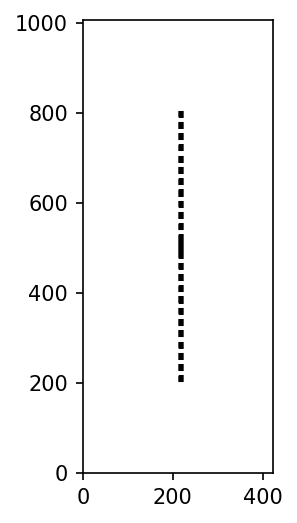

In [6]:
#geometry check
sim.init_fields()
eps_data = sim.get_array(center=mp.Vector3(0,0,0.5*sz-pad-dpml-0.5*tGaAs), 
                                        size=mp.Vector3(sxy,0,sz),
                                        component=mp.Dielectric) #it only contains the vertical cross-section info
plt.figure(dpi=150)
plt.imshow(eps_data, interpolation='none', origin='lower', cmap="Greys")

In [ ]:
#for q values
harminv_instance=mp.Harminv(mp.Ey, mp.Vector3(0,0,0.5*sz-pad-dpml-tGaAs/2), fcen, df)

#for LDOS spectrum
nfreq_ldos=200
ldos_instance = mp.Ldos(fcen,df,nfreq_ldos)

#define box monitor
wvl_flux_min=1.3
wvl_flux_max=1.6
box_dis=0.5
nfreq_box=200
                       
fmin_flux=1/wvl_flux_max
fmax_flux=1/wvl_flux_min
fcen_flux=0.5*(fmin_flux+fmax_flux)
df_flux=fmax_flux-fmin_flux
            
#bottom surface
box_z1 = sim.add_flux(fcen_flux, df_flux, nfreq_box, 
                    mp.FluxRegion(center=mp.Vector3(0,0,0.5*sz-dpml-pad-tGaAs/2-box_dis),
                    size=mp.Vector3(2*box_dis,2*box_dis,0),direction=mp.Z,weight=-1))
#upper surface
box_z2 = sim.add_flux(fcen_flux, df_flux, nfreq_box,
                    mp.FluxRegion(center=mp.Vector3(0,0,0.5*sz-dpml-pad-tGaAs/2+box_dis),
                    size=mp.Vector3(2*box_dis,2*box_dis,0),direction=mp.Z,weight=+1))
#side surface x+
box_x1 = sim.add_flux(fcen_flux, df_flux, nfreq_box, 
                    mp.FluxRegion(center=mp.Vector3(box_dis,0,0.5*sz-dpml-pad-tGaAs/2),
                    size=mp.Vector3(0,2*box_dis,2*box_dis),direction=mp.X,weight=+1))
#side surface x-
box_x2 = sim.add_flux(fcen_flux, df_flux, nfreq_box, 
                    mp.FluxRegion(center=mp.Vector3(-box_dis,0,0.5*sz-dpml-pad-tGaAs/2),
                    size=mp.Vector3(0,2*box_dis,2*box_dis),direction=mp.X,weight=-1))
#side surface y+
box_y1 = sim.add_flux(fcen_flux, df_flux, nfreq_box, 
                    mp.FluxRegion(center=mp.Vector3(0,box_dis,0.5*sz-dpml-pad-tGaAs/2),
                    size=mp.Vector3(2*box_dis,0,2*box_dis),direction=mp.Y,weight=+1))
#side surface y-
box_y2 = sim.add_flux(fcen_flux, df_flux, nfreq_box, 
                    mp.FluxRegion(center=mp.Vector3(0,-box_dis,0.5*sz-dpml-pad-tGaAs/2),
                    size=mp.Vector3(2*box_dis,0,2*box_dis),direction=mp.Y,weight=-1))


sim.run(mp.dft_ldos(ldos=ldos_instance),mp.after_sources(harminv_instance),
            until_after_sources=200)

#extract q values
q_results=[]
    
for mode in harminv_instance.modes:
    q_results.append([1000/mode.freq,mode.decay,mode.Q,abs(mode.amp)]) 
        
q_results = np.array(q_results)
    
for i in range(len(q_results)):
    print("Wavelength in nm:", q_results[i,0])
    print("Decay:", q_results[i,1])
    print("Q factor:", q_results[i,2])
    print("Amplitude:", q_results[i,3])
    print("-")
    
#plot LDOS spectrum    
ldos_results = np.transpose(np.array([mp.get_ldos_freqs(ldos_instance),sim.ldos_data]))
    
    
maximum = max(ldos_results[:, 1])
index = np.where(ldos_results[:, 1] == maximum)
mode_wvl=1000/ldos_results[index, 0]
print('Peak at',mode_wvl,'nm')
    
plt.figure(dpi=150)
plt.plot(1 /ldos_results[:, 0], ldos_results[:, 1], 'b-')
plt.plot(1 /ldos_results[index, 0], ldos_results[index, 1],'r.')
plt.axvline(x=mode_wvl/1000,color='b',linestyle='--') #mark where ldos is maximum
plt.xlabel("Wavelength $\lambda$ ($\mu m$)")
plt.ylabel("LDOS")
plt.title("LDOS of some bullseye structure")
plt.show()

#get power spectrum
flux_freqs = np.array(mp.get_flux_freqs(box_z2))
flux_up = np.array(mp.get_fluxes(box_z2))
flux_z1 = np.array(mp.get_fluxes(box_z1))
flux_x1 = np.array(mp.get_fluxes(box_x1))
flux_x2 = np.array(mp.get_fluxes(box_x2))
flux_y1 = np.array(mp.get_fluxes(box_y1))
flux_y2 = np.array(mp.get_fluxes(box_y2))

flux_total= flux_up+flux_z1+flux_x1+flux_x2+flux_y1+flux_y2
            

flux_wvl=1/flux_freqs

max_uppower = max(flux_up)
max_upindex = np.where(flux_up == max_uppower)
maxwvl=1/flux_freqs[max_upindex] #find the wavelength of maximum
    
plt.figure(dpi=150)
plt.axvline(x=maxwvl,color='b',linestyle='--') #mark where moset productive wavelength
plt.plot(flux_wvl, flux_total, 'r-', label='Total emission')
plt.plot(flux_wvl, flux_z1, 'g-', label='Bottom emission')
plt.plot(flux_wvl, flux_up, 'b-',label='Upward emission')
plt.legend(loc='upper right')
plt.xlabel('Wavelength (µm)')
plt.ylabel('Arbitrary intensity')